<a href="https://colab.research.google.com/github/kniemi641/UC-MScA/blob/master/ML%20Homework%201%20-%20Title.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
# Generic Packages
import pandas as pd
import numpy as np
import math
import os
from scipy import stats

# Model Packages
from sklearn.linear_model import LinearRegression
#from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
#from sklearn.preprocessing import StandardScaler

#Plotting Packages
%matplotlib inline
import matplotlib
import pylab 
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns

#Utility stuff
import warnings
warnings.filterwarnings('ignore')
from google.colab import drive, files
drive.mount('/content/gdrive')

np.random.seed(235)

In [0]:
#INPUT PARAMETERS
NUM=1
INPUT_DATA_FILE='bottle.csv'
NOTEBOOK_NAME='Ambassador {}.ipynb'.format(NUM)

In [0]:
#GLOBAL PARAMETERS
GD_CODE_DIR='/content/gdrive/My Drive/Code/uchicago/'
SUBJECT_DIR='Machine Learning & Predictive Analytics/'
HOMEWORK_DIR='Homework {}'.format(HW_NUM)

#GENERIC PARAMETERS
DATA_DIR='data/'
MODEL_DIR='models/'
LOGS_DIR = 'logs/'

MAIN_PATH=os.path.join(GD_CODE_DIR
                      ,SUBJECT_DIR
                      ,HOMEWORK_DIR)

INPUT_FILE=os.path.join(MAIN_PATH
                       ,DATA_DIR
                       ,INPUT_DATA_FILE)

NOTEBOOK_FILE=os.path.join(MAIN_PATH
                          ,NOTEBOOK_NAME)

MODEL_EXPORT_PATH=os.path.join(MAIN_PATH
                              ,MODEL_DIR)

LOG_PATH=os.path.join(MAIN_PATH
                     ,LOGS_DIR)

# Multivariate Linear Regression

The purpose of this exercise is to create a multivariate linear regression model from the data provided in the "bottle.csv" file. The variables, Salnty & STheta, are used as predictors in the model, and 'T_DegC' will be the response. 

*Sooooooo* what does that exactly mean? 😳

I'm sure some of you are familiar with this concept of a regression and creating a best fit line and getting an equation in the format below:

$y = mx + b$

Often done on scatter plots in excel, used to predict observations based on new data, or measure how well your predictions are doing. But have you ever wondered how exactly excel calculates figures out this equation?

> No??  

Well too bad!! Thats what were gonna do today!
#### Huhzah!
Well thats *almost*  what we'll be doing but more like....

$ y_i =  \beta_1x_1i + \beta_2x_1i + \beta_0x_0i + \epsilon$


where 
* $y_{i}$ is the prediction of the response from our Linear Regression model model for an observation $i$
* $x_{1i}$ and $x_{2i}$ are the values of our predictor variables $x_1$ and $x_2$ at observation  $i$
* $x_{0}$ is a little funky, it represents a 0 value for our predictors 
* $\epsilon$ is our error term and theres plenty more you'll learn about that in the future

In fact $x_{0}$ is exactly the same as our intercept $b$ from the first equation . The value $m$  is represented by the combination of the product of  $X_i$ (all of our predictors in one variable) with  $\beta_i$ (all the coefficients from the model, one per predictor plus intercept):

So once we get this equation we've done our Linear Regression model!

**y** =  $\beta$**$X$** $+\epsilon$

🤯

So **thats** what were going to be doing today! 

Along the way we'll calculate Root Mean Squared Error R-squared using the **sklearn package** and using the **normal equation** to show that the normal equation is indeed equivalent to the sklearn LinearRegression API in sklearn.

## Exploratory Analysis

**It's always a good idea to explore the data you're working with before starting to build any model or even start preprocessing** This seems obvious now but its so important in **literally any model you build**, because ultimitaley you can glean *some business context* which may be present data as its given to you. Lets get some basics out of the way:

*   Use the function **read_csv** from **pd** module to read the data referenced in the variable *INPUT_FILE* (FYI which contains the file input path + name)
*   Turn it into a **dataframe**  often using *df* to denote the data is helpful. A data frame is a **pandas** specific data type in **Python** that makes life very easy for us. You will become more familiar with these in the future. **Dataframes are also used in R, those we''ll be coming at you Stats!**
*   Print a *df*.**describe()**. This describe **method** can help us get a good high level feeling for whats in our data.
*   Print the columns - Lets see what were working whats variables we got!  

Worth going through some time, but not now!
[Documentation - 10 Minutes to pandas](https://pandas.pydata.org/pandas-docs/stable/10min.html)




In [0]:
import pandas as pd

#Load Data and take a look
water_data = pd.read_csv(INPUT_FILE)
water_df = pd.DataFrame(water_data)
print(water_df.describe())
#pass variables into strings using {} & . format \()
print('\n Columns from input file: \n {}'.format(water_df.columns))

             Cst_Cnt        Btl_Cnt         Depthm         T_degC  \
count  864863.000000  864863.000000  864863.000000  853900.000000   
mean    17138.790958  432432.000000     226.831951      10.799677   
std     10240.949817  249664.587269     316.050259       4.243825   
min         1.000000       1.000000       0.000000       1.440000   
25%      8269.000000  216216.500000      46.000000       7.680000   
50%     16848.000000  432432.000000     125.000000      10.060000   
75%     26557.000000  648647.500000     300.000000      13.880000   
max     34404.000000  864863.000000    5351.000000      31.140000   

              Salnty         O2ml_L         STheta          O2Sat  \
count  817509.000000  696201.000000  812174.000000  661274.000000   
mean       33.840350       3.392468      25.819394      57.103779   
std         0.461843       2.073256       1.167787      37.094137   
min        28.431000      -0.010000      20.934000      -0.100000   
25%        33.488000       1.3600

The *.describe()* method on the *water_df* printed some high level statistics about each column in the dataframe: Mean, Quantiles, Standard Deviation, etc... These can be useful to know in any dataset! 

But for this exercise we only care about using the predictors 'Salnty' and 'STheta' on the response variable 'T_degC'. The model we will be making is a linear regression. If you don't know exactly what that it is its ok! By the end of Statistical Analysis you'll have a deep understanding of the assumptions and workings of these models and others!

Next lets do a bit of cleaning and inspecting. **This is an often underemphasized step in many classes, but a majority of time spent on a project can spent just doing cleaning! So get comfortable with it!** 

* First we use the only grab the data from our df with the notnull values in the columns we care about
* Define Predictors & Response
* Create our X and y dataframes from our predictors and response
* Create histograms of the distributions of our x and y variables


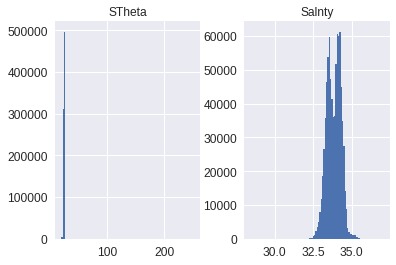

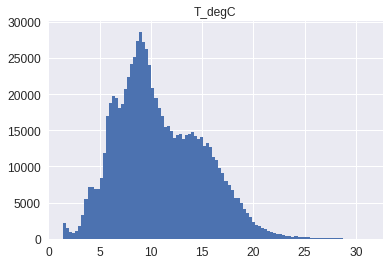

In [0]:
# Remove observations with nulls
water_df_clean = water_df[water_df.Salnty.notnull() 
                          & water_df.STheta.notnull() 
                          & water_df.T_degC.notnull()]

#could use this!
#water_df_clean = water_df.dropna()

# Variable name definition
predictors = ['Salnty', 'STheta']
response = ['T_degC']

# Create our X variable from the predictors
X_df = water_df_clean[predictors]
y_df = water_df_clean[response]

# Lets see the distribution
X_df.hist(bins=100)
y_df.hist(bins=100)

# Don't worry about the intercept for now
X_df['Intercept'] = 1

Hmmmm, something doesn't look right with 'STheta'  🤔

Maybe there are some outliers? A relatively common problem in any data set. These could be abnormal in your context or even errors in the recording of the data. Its all dependent on the *context of your problem*. 

Everything seems to be concentrated closer to 0 on the scale. So lets make a cut off of 100, and we will drop every observation with an STheta greater than the cutoff.

**THIS IS AN ASSUMPTION I AM MAKING ABOUT THE DATA, THESE ARE OK TO DO BUT YOU SHOULD BE ABLE TO JUSTIFY IT IN THE CONTEXT OF THE PROBLEM**

* Print the shapes of the Dataframes X & y, a good habit
* Create X & y variables by using and index filled  with True or False based on boolean logic applied to the Stheta values. Only grab TRUE values (by definition)
* Print the shape shape of X and y variables


 Shape of Response DF:   (812174, 1)

 Shape of Predictors DF: (812174, 3)

 Shape of X:   (812168,)

 Shape of y:   (812168, 3)

 Distribution of STheta w/ outliers removed:

AxesSubplot(0.125,0.125;0.775x0.755)


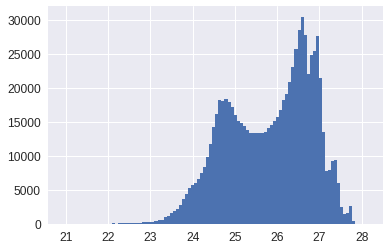

In [0]:
stheta_cut_off = 100
# Checking shapes is a good habit to get into
print('\n Shape of Response DF:   {}'.format(y_df.shape))
print('\n Shape of Predictors DF: {}'.format(X_df.shape))

# Note : Order matters here, we are using an index from one dataframe
# to alter another, so be careful about the dependent index!

y = y_df[X_df['STheta'].values < stheta_cut_off].values.ravel()
X = X_df[X_df['STheta'].values < stheta_cut_off].values

# Checking shapes is a good habit to get into
print('\n Shape of X:   {}'.format(y.shape))
print('\n Shape of y:   {}'.format(X.shape))

#Histogram of Stheta using our logic, don't worry too much about this piece
hist = X_df[X_df['STheta'].values < stheta_cut_off]['STheta'].hist(bins=100)
print('\n Distribution of STheta w/ outliers removed:\n\n{}'.format(hist))


Ah much better! The "STheta" predictor has a distribution similar to what we may expect (*context of the problem I am assuming about*)

We can see from our print statements we removed 6 observations from our data, the first value in the shape (the rows) has decreased. 

 The shape y is 1-dimensional, think of it as a number line where the observations are tick marks on the line. When there was a second dimension, this was representitive of a 2-d box with $n$ rows and 1 column. That is what our .**ravel()** method did, it unrolled the box into a line. 
 
 Doing this step is not required per-se, but will make our life easier in the long run. So if you have a 2D response with $n$ rows and 1 column, consider making it into a 1 dimensional vector using ``.ravel().`` on the end of your values.

---

Scatter plots are also useful for to give you some broad characteristics of the data. For instance below we can see there seems to be a positive relationship between the $x_1$ predictor and the response, and a negative relationship for the predictor $x_2$. 

Here I am using a library called **py_plot** which is a sub module of **matplotlib**. I won't go into the specifics now.

See more here [matplotlib](https://matplotlib.org/) and : [py_plot documentation](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html)

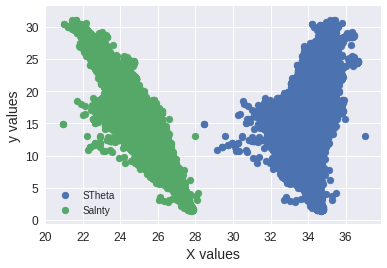

In [0]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0],y,label='STheta')  #specify label for the corresponding curve
plt.scatter(X[:,1],y,label='Salnty')  #-don't worry about it for now.
plt.grid(True)
plt.legend()
plt.xlabel('X values')
plt.ylabel('y values')
plt.show()


Making plots like these are good habits to get into. In more complicated models you may transform the data you won't know which way up is! And doing some visualizing before making more complicated data structures is a great place to give some sense of direction.

We won't be doing this today, BUT if you'd like to learn about what you might see in classes like "Machine Learning & Predictive Analytics" take a look at something like TF-IDF, a way to represent text data in numeric feature vector space.
[sklearn tf-idf vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)

## Sklearn : Linear Regression Model

The Linear Regression function from the **very useful sci-kit learn library** helps use create our Linear Regression model. We are using Python today, but the same concepts should apply in R, another statiscial lanuage you are going to see first. 

Learn more about sci-kit learn []()

Learn more about R: []()

---
First the Linear Regression model $lr$ is iniated using the function call. We then use the ``.fit`` method on our predictors ``X`` and response ``y``. We just performed a linear regression! 🤓

We then extract the coefficients by accessing the $lr$ models' attributes. These are the $\beta$ vector we need we need for our equation! These predictors can then be used in the equation below to give a **prediction** about our response, y hat

$ \hat{y}=  \beta_1*x_{1i} + \beta_2*x_{2i} + \beta_0$


If terms like modules, API calls, methods, attributes got you worried don't worry! Theres a **Python for Analytics Course** to get you ready!

In [0]:
from sklearn.linear_model import LinearRegression

# Create Linear model and fit it with our data!
lr = LinearRegression()
lr.fit(X, y)

# Get Coefficients from model
lr_intercept = np.array( [lr.intercept_] )
lr_coeffs = np.array([lr.coef_[:2]])

#Dataframe of coefficients
lr_parameters = pd.DataFrame(np.concatenate((lr_coeffs.T, lr_intercept.reshape(1,1))))
lr_parameters.columns = ['Betas']
lr_parameters.rename(index={0:'Salnty (Beta_1)',1:'STheta (Beta_2)', 2:'Intercept'}, inplace=True)
print(round(lr_parameters, 4))

                   Betas
Salnty (Beta_1)   3.1084
STheta (Beta_2)  -5.0376
Intercept        35.7088


Our Linear Regression model determines *best fit* by using a ``score`` which is stored for the best model (in this case). All sklearn models will have a 'score' attribute of some kind. They just may be different scoring methods! 


---

See more [here](https://scikit-learn.org/stable/modules/model_evaluation.html)! If this looks overwhelming, have no fear! **Data Mining Principles** is Here!

---

For Linear Regression the scoring method is R-squared and can be obtained from the model object **after it has been fit**, this is true for all models. Think about it, you need to fit something to your data to evaluate it. 

R-Squared represents the ratio of *variance explained* by the model to *total variance* of the data it used to create the model. Much more to come on this in **Statistical Analysis** 

The Root Mean Squared Error is another common metric you will see used in statistical models. RMSE is calculated by

* Taking the difference between the true $y_i$ value from the data (for each observation $i$) and the predicted $\hat{y_i}$ value generated by the model parameters. **Fundamentally this is what a model is: a data generating process given a set of parameters**
* Squaring this value for each observation, so our negatives errors don't offset our positive errors
* Summing theses values for all observations in the data (this is why we square!)
* Taking the square root

Ta dah! RMSE represents on average the deviance of a model predicted value to an observation. 

In [0]:
# R Squared
lr_score = lr.score(X, y)

# Predictionlr_s
lr_y_hat = lr.predict(X)
lr_residuals = y - lr_y_hat

#RMSE and VAF

lr_RMSE = math.sqrt(mean_squared_error(y, lr_y_hat))
lr_VAF_score = explained_variance_score(y, lr_y_hat)

print('Linear Regression R-Squared: {}'.format(round(lr_score, 4)))
print('Linear Regression RMSE: {}'.format(round(lr_RMSE,4)))
# skip this for now
#print('Linear Regression Variance Explained: {}'.format(round(lr_VAF_score, 4)))

Linear Regression R-Squared: 0.9869
Linear Regression RMSE: 0.4829


Wow our R-Squared is very high! The range on this scoring metric is 0 to 1. If we have a value very close to 1, it means our model is explaining a lot of the variance in the data. Our model has done a good job at picking the best parameters which represent the data! 

**NOTE: if R-Squared is ever exactly 1.0 you have overfit your model! This is one of the most import concepts to grasp in the Machine Learning: underfitting and overfitting and how you can tune your model to get the best results by balancing these concepts. You will talk about this in every single one of your classes I guarantee it!**

For just a peek at some ideas you'll take a look at later in Statisical Analysis. See the plot of our residuals below. Remember, the residuals are differences between the true $y$ values and the predicted $\hat{y}$ values from our model. They are the 'error' associated with the predictions from our model. 

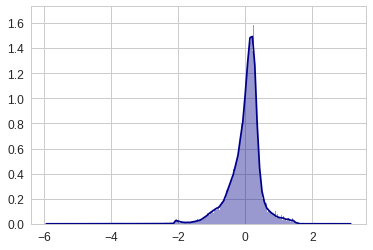

In [0]:
def plot_model_resids(array):
    sns.set_style('whitegrid')
    sns.distplot(array
                 , hist=True
                 , kde=True
                 , bins=int(len(array) / 100)
                 , color = 'darkblue'
                )
                 
    
plot_model_resids(lr_residuals)


Here we are checking the assumptions about our model. We assumed some things implicitly when we made a Linear Regression. Statistical Analysis will explore this very deeply.

**Challenge**

Notice how the graph is centered close to 0, and has an awfuly familar shape some of you may recognize as: the bell curve or normal distribution or guassian, blah blah. You're gonna see alot of ' now'.

Is there something this is telling us (good or bad!) about our assumptions in our Linear Regression Model? 🤔 What was that $\epsilon$ term all about from before?

---



##Normal Equation Calculation Model

Wow sklearn seems to be a powerful library!  💪

I cannot emphasize enough the value of reading the documentation before, during, or after using a specific function or package. Its a worthwhile exercise to go through some trouble shooting a specific function using exclusively the documenation before reaching out for help. Learning how to navigate and use documentation might be your most important skill set for success here. [Heres the very extensive sklearn library](https://scikit-learn.org/stable/index.html)

---

But how exactly are the parameters for the 'best fit' model calculated? We fed in a  matrix $X$ and vector $y$ and then . . .  👏 Got our model! How??

Underneath the hood,  most sklearn models are 'fit' by running algorithms computing different linear algebra equations. If some of you haven't done that before thats ok. We have a **Linear Algebra Class** aimed at getting you some solid understanding of how Linear Algebra is really the toolkit of most machine learnings. You don't need to be an expert, but to really get a comprehnsive understanding of how the packages work, when and why to use them, understanding concepts like dot products and transposing is important.


---

One of the most useful equations is the *normal* equation which gives the best fit model for a *normal* distribution, which is what we assuming we have! Remember that $\epsilon$ from before? we are assuming something about how the errors are distributed when we create the standard linear regression. More on that later

The Beta coefficients for a linear regression can solved for using the linear algebra package & all around workhorse **numpy**. This is up there in importance with sklearn for Python.

The solution to this equation gives the best coefficients for a model based on the X and y provided.

In [0]:
#(X.T . X)^-1 . (X.T * y)
NE_params = np.dot(
              #INV:
              np.linalg.inv(
                # X.T * X 
                np.dot(np.transpose(X),X))
            , # X.T * Y
              np.dot(np.transpose(X), y)
                  )

NE_params = pd.DataFrame(NE_params)
NE_params.columns = ['Coefficients']
NE_params.rename(index={0:'Salnty',1:'STheta', 2:'Intercept'}, inplace=True)
print(round(NE_params, 4))

           Coefficients
Salnty           3.1084
STheta          -5.0376
Intercept       35.7088


🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯🤯


---

Next I calculate the yhat predictions from the parameters just solved for. Then the residuals, then $SSE$ the sum of squares This concept should seem familiar to what we did for RMSE, but not exactlyl! Notice we calculate the $SST$ or Sum of squares total, which is the same as $SSE$ except the 'difference' part is between the y value and $\bar{y}$, which is the average for all $y_i$. So the total some of square is the difference between each observation and the predictors average. We then calculate $R^2 = 1 - \frac{SSE}{SST}$


In [0]:
#Predictions , residuals, and SSE
NE_yhat = np.array((np.dot(X, NE_params))).T
NE_residuals = np.array(NE_yhat - y)
NE_SSE = np.sum(np.square(NE_residuals)) 

#Ybar and SST
y_bar = np.repeat(np.average(y), y.size)
NE_SST = np.sum(np.square(np.subtract(y_bar, y)))

#Rsquared from SSE & SST
NE_Rsquared = 1-(NE_SSE/NE_SST)

#RMSE & VAF
NE_RMSE = np.sqrt(np.sum(np.square(NE_yhat-y))/NE_yhat.size)
NE_VAF = 1-np.cov(np.array(np.array(y) - np.array(NE_yhat)).flatten())/np.cov(y)

print('Normal Equation R Squared:{}'.format(round(NE_Rsquared, 4)))
print("Normal Equation RMSE: {}".format(round(NE_RMSE,4)))
print('Normal Equation Variance Explained:{}'.format(round(NE_VAF, 4)))

Normal Equation R Squared:0.9869
Normal Equation RMSE: 0.4829
Normal Equation Variance Explained:0.9869


We get the same values!!!!! Hopefully you can kind of get a scope of things you're going to see. Statistics, Linear Algebra, Machine Learning Librarys.

There's so much more!

In [0]:
!jupyter nbconvert --to html '$NOTEBOOK_FILE'

[NbConvertApp] Converting notebook /content/gdrive/My Drive/Code/uchicago/Machine Learning & Predictive Analytics/Homework 1/Homework 1.ipynb to html
[NbConvertApp] Writing 400570 bytes to /content/gdrive/My Drive/Code/uchicago/Machine Learning & Predictive Analytics/Homework 1/Homework 1.html
